In [1]:
# Install required packages with specific versions
# !pip install torch==2.6.0 --extra-index-url https://download.pytorch.org/whl/cu124
# !pip install numpy==1.26.4
# !pip install matplotlib==3.10.1

In [ ]:
# import everything here...
%load_ext autoreload
%autoreload 2
from RL_utils import *
%matplotlib inline

In [ ]:
# create env
import gym
env = gym.make("CartPole-v0",render_mode="human") # 
config = Config(learning_rate=0.001, DBM=True) # 使用默认配置
if config.DBM:
    config.print_cfg()
set_seed(config)

--- config ---
max_episode: 1000
max_steps: 100
learning_rate: 0.001
gamma: 0.99
epsilon: 0.1
seed: 42
tau: 0.01
------------


e:\anaconda\envs\llama_factory\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [ ]:
# value network construction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config.DBM:
    print("using device:",device)
env_cfg = Env_Config(obdim=env.observation_space.shape[0],acdim=env.action_space.n)
if config.DBM:
    env_cfg.print_cfg()
epsilon = Epsilon(original_val=1, min_val=0.1, liner_decay=1/2000)
warmup = 200
rewardnorm = RewardNormalizer(capacity = warmup)
sarsa = SARSA(config=config, epsilon = epsilon, env_config=env_cfg, device = device) # optimizer inside of sarsa

using device: cuda
obdim: 4
acdim: 2


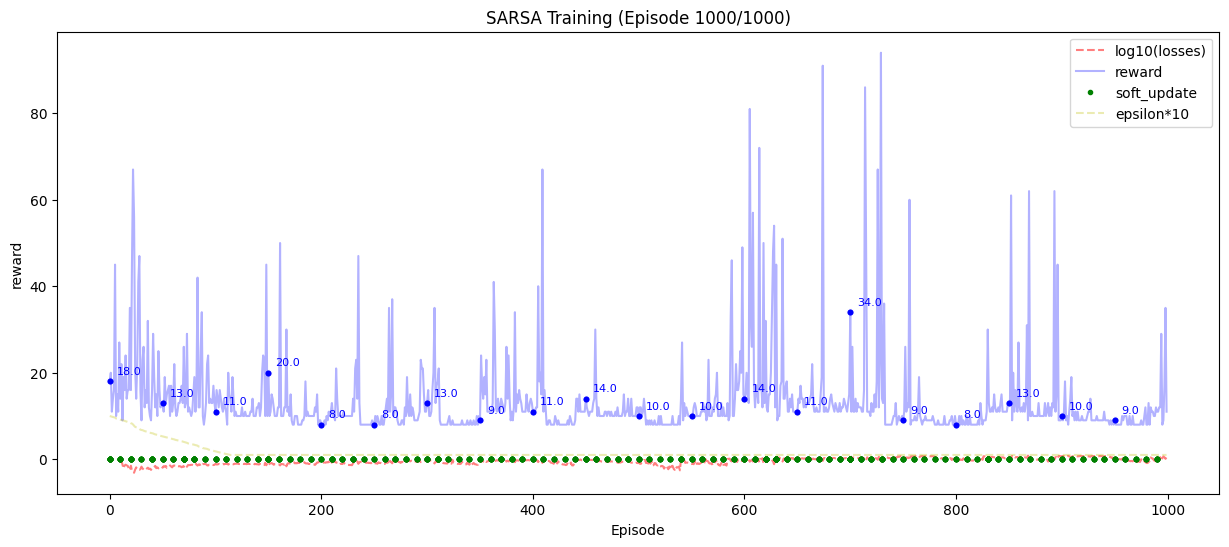

In [ ]:
rewards = []
losses = []
total_steps = 0 # 这个是总的全部的步数
log = defaultdict(list)
log["soft_update_x"].append(total_steps)
log["soft_update_y"].append(0)

# training loop here
for episode_num in range(config.max_episode):
    state, info = env.reset(seed=config.seed)
    done = False
    total_reward = 0 # 这个是这个轮次的总的reward
    action = select_action(state=state, env=env, model = sarsa.model, epsilon = epsilon, config=config, device=device, update_epsilon = True)
    episode_losses = []
    log["epsilon"].append(epsilon.epsilon*10)
    while True:
        next_state, reward, done, truncated, info = env.step(action = action)
        #reward = rewardnorm.reward_func(env, *next_state)
        total_steps+=1
        if config.DBM:
            print_(reward)
        if done:
            next_state = None
        predicted_action = select_action(state=next_state, env=env, model = sarsa.model, epsilon = epsilon, config=config, device=device, update_epsilon = True)
        if total_steps >= warmup:
            #rewardnorm.update()
            #norm_reward = rewardnorm.normalize(reward)
            if config.DBM:
                # print_(norm_reward)
                pass
            loss = sarsa.update(state=state, action=action, reward=reward, next_state=next_state, predicted_action=predicted_action,device=device,config = config)
            episode_losses.append(loss)
        state = next_state
        total_reward += reward
        # 新修改为使用predicted_action
        action = predicted_action
        if done or truncated:
            break
        if episode_num%10 == 0:# 参考代码中是每个轮次都要进行一次soft_update的哎。尝试过效果也不好。就这样的了。
            soft_update(target_network=sarsa.target_model,source_network=sarsa.model,tau = config.tau)
            log["soft_update_x"].append(episode_num)
            log["soft_update_y"].append(0)
    losses.append(np.mean(episode_losses)) if episode_losses is not [] else losses.append(0)
    rewards.append(total_reward)
    draw_in_ipynb(x_s = [None,None,log["soft_update_x"],None], y_s=[[np.log10(loss) for loss in losses],rewards,log["soft_update_y"],log["epsilon"]], alpha_s=[0.5,0.3,1,0.3], label_s=["log10(losses)","reward","soft_update","epsilon*10"], mark_s=["r--","b-","g.","y--"],config=config)